In [142]:
import pandas as pd
import numpy as np
import io
from google.colab import files
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, GRU, Conv1D, Flatten
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [143]:
# Load the data
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['LSTM_Proj.csv']))


df_clean = df.dropna(subset=['sector_performance_1week', 'sector_performance_5week',
                             'sector_performance_20week', 'index_performance_1week',
                             'index_performance_5week', 'index_performance_20week',
                             'company_performance_1week', 'company_performance_5week',
                             'company_performance_20week', 'twentyfour_hr_post_release%change'])

X = df_clean[['sector_performance_1week', 'sector_performance_5week',
              'sector_performance_20week', 'index_performance_1week',
              'index_performance_5week', 'index_performance_20week',
              'company_performance_1week', 'company_performance_5week',
              'company_performance_20week']]

Y = df_clean['twentyfour_hr_post_release%change']


Saving LSTM_Proj.csv to LSTM_Proj (15).csv


In [157]:
# Normalizing data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

y_scaler = MinMaxScaler()
y = y_scaler.fit_transform(np.array(Y).reshape(-1, 1))

# Training and testing sets
train_size = int(0.8 * len(df))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape the input data for LSTM input
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Defining LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(1, X_train.shape[2])))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # One output neurons

# Compiling the model
model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mean_absolute_error'])

# Fit the model to the training data
model.fit(X_train, y_train, epochs=200, batch_size=36, verbose=1)

# Evaluate the model on the test data
score = model.evaluate(X_test, y_test, batch_size=16, verbose=1)
print('Test score:', score)

# Using the model to make predictions on new data
X_new = np.array([[0.2, 0.3, 0.4, 0.1, 0.2, 0.3, 0.05, 0.1, 0.15]])
X_new = scaler.transform(X_new)
X_new = np.reshape(X_new, (X_new.shape[0], 1, X_new.shape[1]))
y_pred = model.predict(X_new)
y_pred = y_scaler.inverse_transform(y_pred)
print('Predicted changes in price after 1 day:', y_pred)

Epoch 1/200
3/3 [==============================] - 3s 7ms/step - loss: 0.3498 - mean_absolute_error: 0.5526
Epoch 2/200
3/3 [==============================] - 0s 6ms/step - loss: 0.2738 - mean_absolute_error: 0.4824
Epoch 3/200
3/3 [==============================] - 0s 6ms/step - loss: 0.2138 - mean_absolute_error: 0.4204
Epoch 4/200
3/3 [==============================] - 0s 5ms/step - loss: 0.1628 - mean_absolute_error: 0.3622
Epoch 5/200
3/3 [==============================] - 0s 6ms/step - loss: 0.1177 - mean_absolute_error: 0.3088
Epoch 6/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0835 - mean_absolute_error: 0.2568
Epoch 7/200
3/3 [==============================] - 0s 7ms/step - loss: 0.0616 - mean_absolute_error: 0.2151
Epoch 8/200
3/3 [==============================] - 0s 7ms/step - loss: 0.0532 - mean_absolute_error: 0.1826
Epoch 9/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0540 - mean_absolute_error: 0.1786
Epoch 10/200
3/3 [==========

1/1 [==============================] - 0s 24ms/step


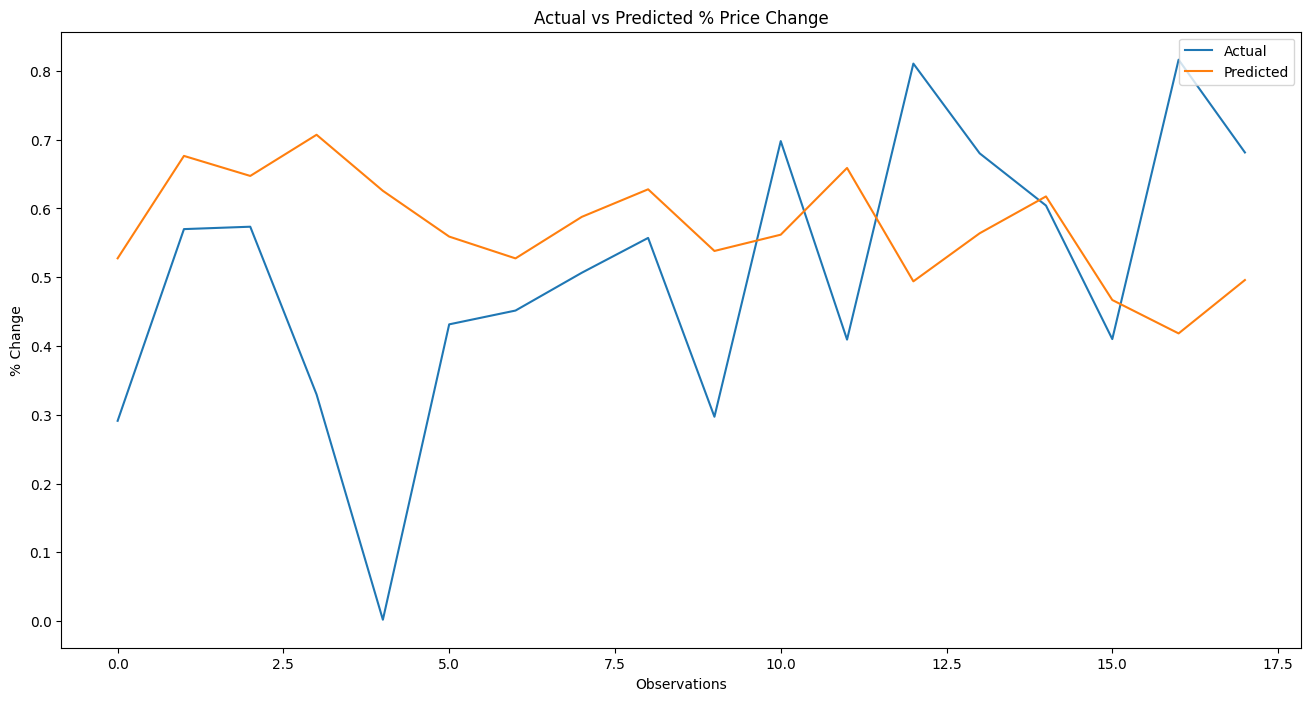

In [158]:
y_pred = model.predict(X_test)

y_pred = y_pred.flatten()
y_test = y_test.flatten()

plt.figure(figsize=(16, 8))

plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')

plt.title('Actual vs Predicted % Price Change')
plt.xlabel('Observations')
plt.ylabel('% Change')
plt.legend(loc='upper right')
plt.show()

In [68]:
# Function to create model, required for KerasRegressor
def create_model(optimizer='adam', neurons=50):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(1, X_train.shape[2])))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

# create model
model = KerasRegressor(build_fn=create_model, verbose=0)

# define the grid search parameters
neurons = [50, 100, 150]
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]

param_grid = dict(neurons=neurons, optimizer=optimizer, batch_size=batch_size, epochs=epochs)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

<ipython-input-68-44ee0f447f5c>:11: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best: -0.045163 using {'batch_size': 80, 'epochs': 100, 'neurons': 150, 'optimizer': 'SGD'}


In [110]:
from keras.optimizers import SGD

# Define the model
model = Sequential()
model.add(LSTM(150, input_shape=(1, X_train.shape[2])))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1)) 

sgd = SGD(learning_rate=0.01)

# Compile the model
model.compile(loss='mse', optimizer=sgd, metrics=['mse'])

# Fit the model to the training data
model.fit(X_train, y_train, epochs=100, batch_size=80, verbose=1)

# Evaluate the model on the test data
score = model.evaluate(X_test, y_test, batch_size=16, verbose=1)
print('Test score:', score)

# Use the model to make predictions on new data
X_new = np.array([[0.2, 0.3, 0.4, 0.1, 0.2, 0.3, 0.05, 0.1, 0.15, 0.4, 0.05]])
X_new = scaler.transform(X_new)
X_new = np.reshape(X_new, (X_new.shape[0], 1, X_new.shape[1]))
y_pred = model.predict(X_new)
y_pred = y_scaler.inverse_transform(y_pred)
print('Predicted changes in price after 1 day:', y_pred)



Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.3754 - mse: 0.3754
Epoch 2/100
1/1 [==============================] - 0s 15ms/step - loss: 0.3469 - mse: 0.3469
Epoch 3/100
1/1 [==============================] - 0s 13ms/step - loss: 0.3212 - mse: 0.3212
Epoch 4/100
1/1 [==============================] - 0s 15ms/step - loss: 0.2976 - mse: 0.2976
Epoch 5/100
1/1 [==============================] - 0s 16ms/step - loss: 0.2764 - mse: 0.2764
Epoch 6/100
1/1 [==============================] - 0s 15ms/step - loss: 0.2574 - mse: 0.2574
Epoch 7/100
1/1 [==============================] - 0s 14ms/step - loss: 0.2405 - mse: 0.2405
Epoch 8/100
1/1 [==============================] - 0s 15ms/step - loss: 0.2257 - mse: 0.2257
Epoch 9/100
1/1 [==============================] - 0s 14ms/step - loss: 0.2124 - mse: 0.2124
Epoch 10/100
1/1 [==============================] - 0s 15ms/step - loss: 0.2002 - mse: 0.2002
Epoch 11/100
1/1 [==============================] - 0s 13ms/step - loss

In [159]:
def create_model():
    model = Sequential()
    model.add(LSTM(64, input_shape=(1, X_train.shape[2])))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))  # One output neurons

    # Compiling the model
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mean_absolute_error'])
    return model

model = KerasRegressor(build_fn=create_model, epochs=200, batch_size=36, verbose=1)

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# define 5-fold cross validation test harness
kfold = KFold(n_splits=5, shuffle=True)
results = cross_val_score(model, X_train, y_train, cv=kfold)

print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))


<ipython-input-159-3afcf7bf6c11>:12: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, epochs=200, batch_size=36, verbose=1)


Epoch 1/200
2/2 [==============================] - 2s 10ms/step - loss: 0.3721 - mean_absolute_error: 0.5704
Epoch 2/200
2/2 [==============================] - 0s 8ms/step - loss: 0.3354 - mean_absolute_error: 0.5386
Epoch 3/200
2/2 [==============================] - 0s 8ms/step - loss: 0.3065 - mean_absolute_error: 0.5117
Epoch 4/200
2/2 [==============================] - 0s 8ms/step - loss: 0.2806 - mean_absolute_error: 0.4881
Epoch 5/200
2/2 [==============================] - 0s 8ms/step - loss: 0.2542 - mean_absolute_error: 0.4637
Epoch 6/200
2/2 [==============================] - 0s 13ms/step - loss: 0.2264 - mean_absolute_error: 0.4367
Epoch 7/200
2/2 [==============================] - 0s 8ms/step - loss: 0.1981 - mean_absolute_error: 0.4068
Epoch 8/200
2/2 [==============================] - 0s 12ms/step - loss: 0.1715 - mean_absolute_error: 0.3774
Epoch 9/200
2/2 [==============================] - 0s 17ms/step - loss: 0.1430 - mean_absolute_error: 0.3430
Epoch 10/200
2/2 [======

Epoch 1/200
2/2 [==============================] - 2s 15ms/step - loss: 0.3360 - mean_absolute_error: 0.5440
Epoch 2/200
2/2 [==============================] - 0s 13ms/step - loss: 0.3000 - mean_absolute_error: 0.5099
Epoch 3/200
2/2 [==============================] - 0s 13ms/step - loss: 0.2741 - mean_absolute_error: 0.4848
Epoch 4/200
2/2 [==============================] - 0s 13ms/step - loss: 0.2504 - mean_absolute_error: 0.4601
Epoch 5/200
2/2 [==============================] - 0s 12ms/step - loss: 0.2262 - mean_absolute_error: 0.4348
Epoch 6/200
2/2 [==============================] - 0s 16ms/step - loss: 0.2007 - mean_absolute_error: 0.4082
Epoch 7/200
2/2 [==============================] - 0s 8ms/step - loss: 0.1748 - mean_absolute_error: 0.3765
Epoch 8/200
2/2 [==============================] - 0s 9ms/step - loss: 0.1485 - mean_absolute_error: 0.3440
Epoch 9/200
2/2 [==============================] - 0s 9ms/step - loss: 0.1246 - mean_absolute_error: 0.3156
Epoch 10/200
2/2 [====

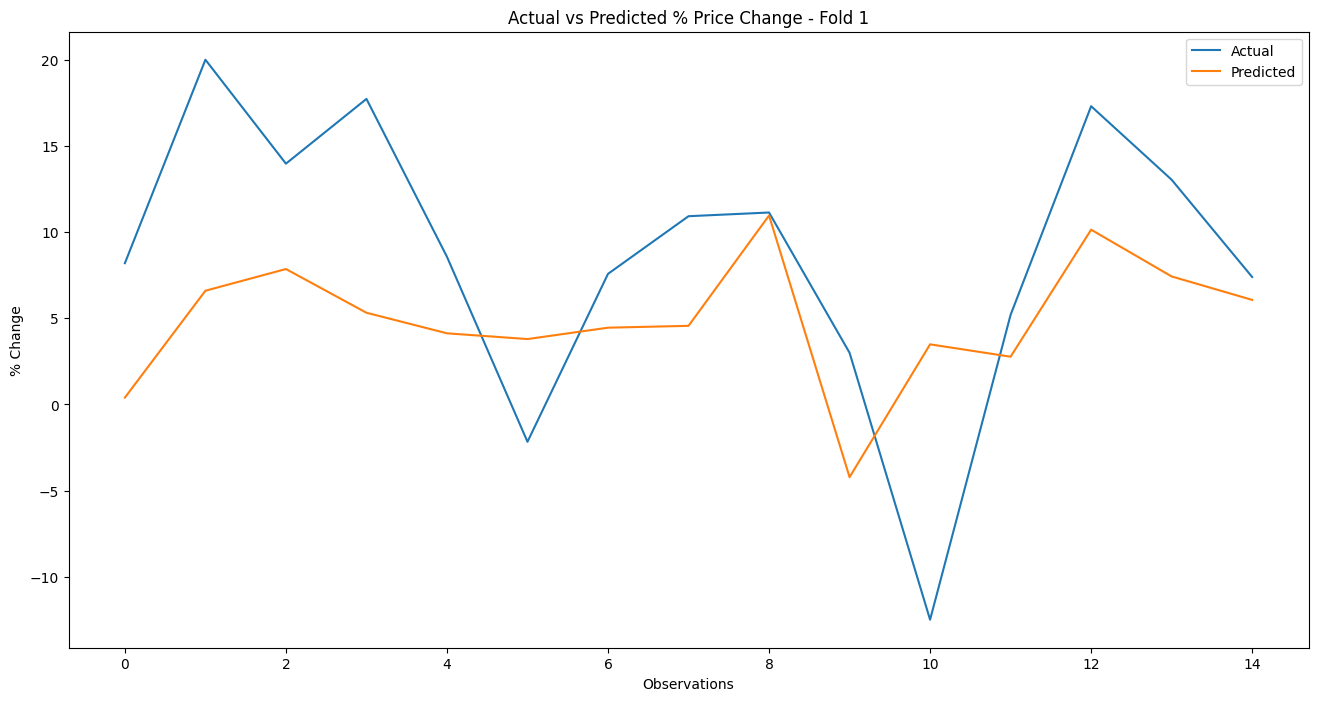

Epoch 1/200
2/2 [==============================] - 3s 11ms/step - loss: 0.3416 - mean_absolute_error: 0.5399
Epoch 2/200
2/2 [==============================] - 0s 11ms/step - loss: 0.3129 - mean_absolute_error: 0.5141
Epoch 3/200
2/2 [==============================] - 0s 10ms/step - loss: 0.2871 - mean_absolute_error: 0.4899
Epoch 4/200
2/2 [==============================] - 0s 10ms/step - loss: 0.2596 - mean_absolute_error: 0.4633
Epoch 5/200
2/2 [==============================] - 0s 12ms/step - loss: 0.2320 - mean_absolute_error: 0.4363
Epoch 6/200
2/2 [==============================] - 0s 9ms/step - loss: 0.2055 - mean_absolute_error: 0.4079
Epoch 7/200
2/2 [==============================] - 0s 8ms/step - loss: 0.1780 - mean_absolute_error: 0.3760
Epoch 8/200
2/2 [==============================] - 0s 15ms/step - loss: 0.1522 - mean_absolute_error: 0.3474
Epoch 9/200
2/2 [==============================] - 0s 8ms/step - loss: 0.1276 - mean_absolute_error: 0.3211
Epoch 10/200
2/2 [====

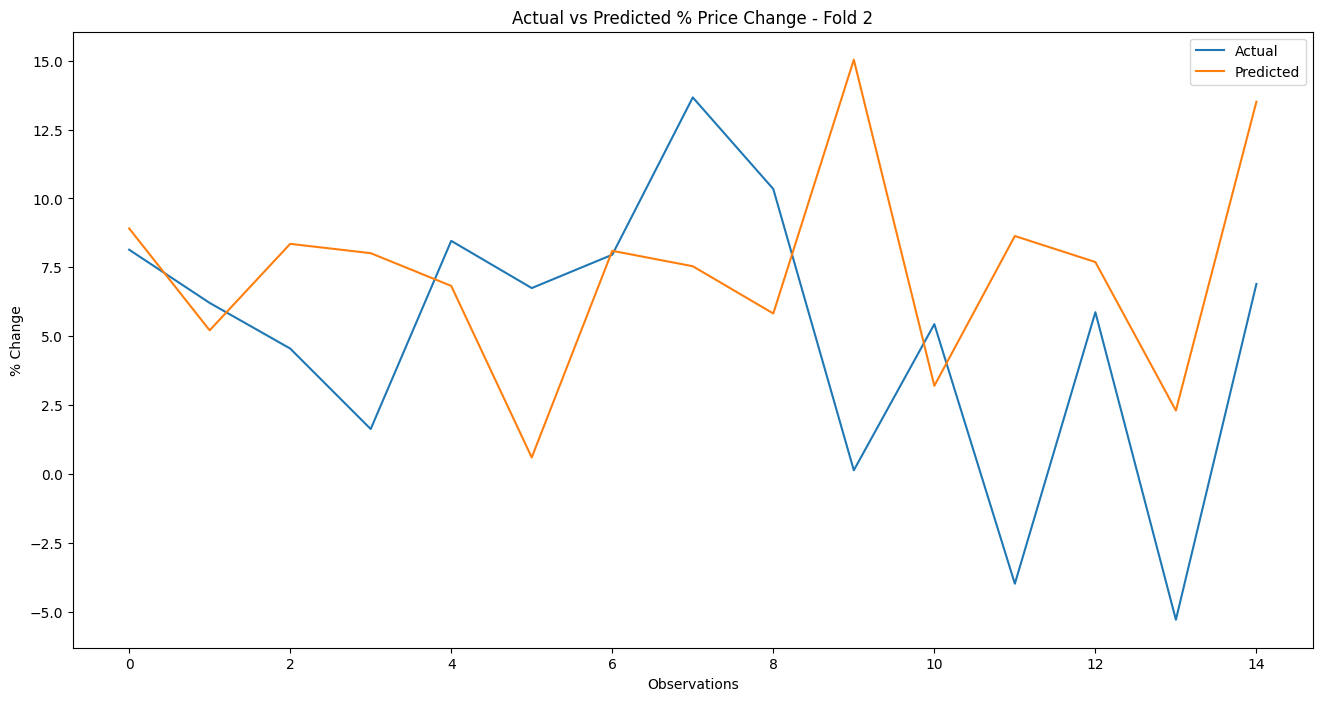

Epoch 1/200
2/2 [==============================] - 3s 13ms/step - loss: 0.4020 - mean_absolute_error: 0.6004
Epoch 2/200
2/2 [==============================] - 0s 10ms/step - loss: 0.3712 - mean_absolute_error: 0.5748
Epoch 3/200
2/2 [==============================] - 0s 11ms/step - loss: 0.3439 - mean_absolute_error: 0.5515
Epoch 4/200
2/2 [==============================] - 0s 11ms/step - loss: 0.3223 - mean_absolute_error: 0.5323
Epoch 5/200
2/2 [==============================] - 0s 12ms/step - loss: 0.3038 - mean_absolute_error: 0.5154
Epoch 6/200
2/2 [==============================] - 0s 10ms/step - loss: 0.2825 - mean_absolute_error: 0.4944
Epoch 7/200
2/2 [==============================] - 0s 9ms/step - loss: 0.2571 - mean_absolute_error: 0.4693
Epoch 8/200
2/2 [==============================] - 0s 9ms/step - loss: 0.2299 - mean_absolute_error: 0.4399
Epoch 9/200
2/2 [==============================] - 0s 10ms/step - loss: 0.2026 - mean_absolute_error: 0.4098
Epoch 10/200
2/2 [===

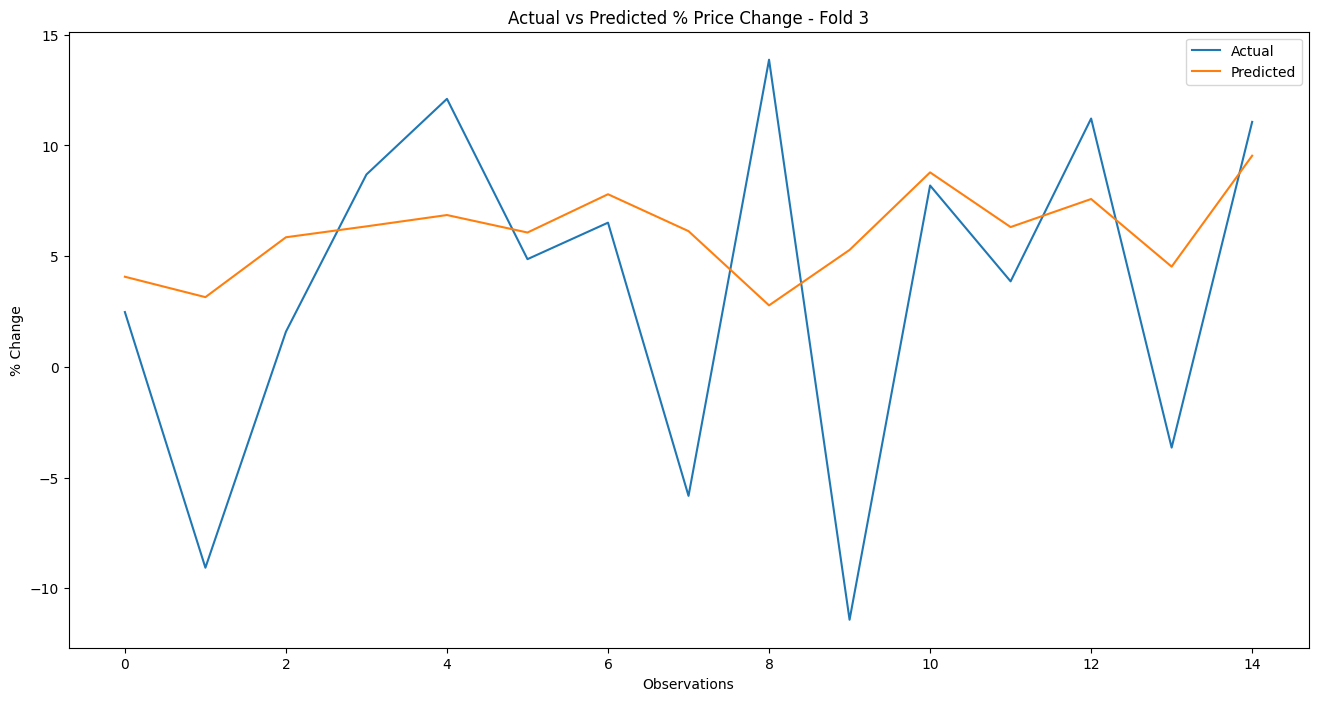

Epoch 1/200
2/2 [==============================] - 2s 12ms/step - loss: 0.3465 - mean_absolute_error: 0.5478
Epoch 2/200
2/2 [==============================] - 0s 8ms/step - loss: 0.3131 - mean_absolute_error: 0.5175
Epoch 3/200
2/2 [==============================] - 0s 7ms/step - loss: 0.2809 - mean_absolute_error: 0.4882
Epoch 4/200
2/2 [==============================] - 0s 8ms/step - loss: 0.2497 - mean_absolute_error: 0.4575
Epoch 5/200
2/2 [==============================] - 0s 10ms/step - loss: 0.2195 - mean_absolute_error: 0.4269
Epoch 6/200
2/2 [==============================] - 0s 10ms/step - loss: 0.1904 - mean_absolute_error: 0.3928
Epoch 7/200
2/2 [==============================] - 0s 9ms/step - loss: 0.1630 - mean_absolute_error: 0.3605
Epoch 8/200
2/2 [==============================] - 0s 11ms/step - loss: 0.1352 - mean_absolute_error: 0.3279
Epoch 9/200
2/2 [==============================] - 0s 11ms/step - loss: 0.1117 - mean_absolute_error: 0.3002
Epoch 10/200
2/2 [=====

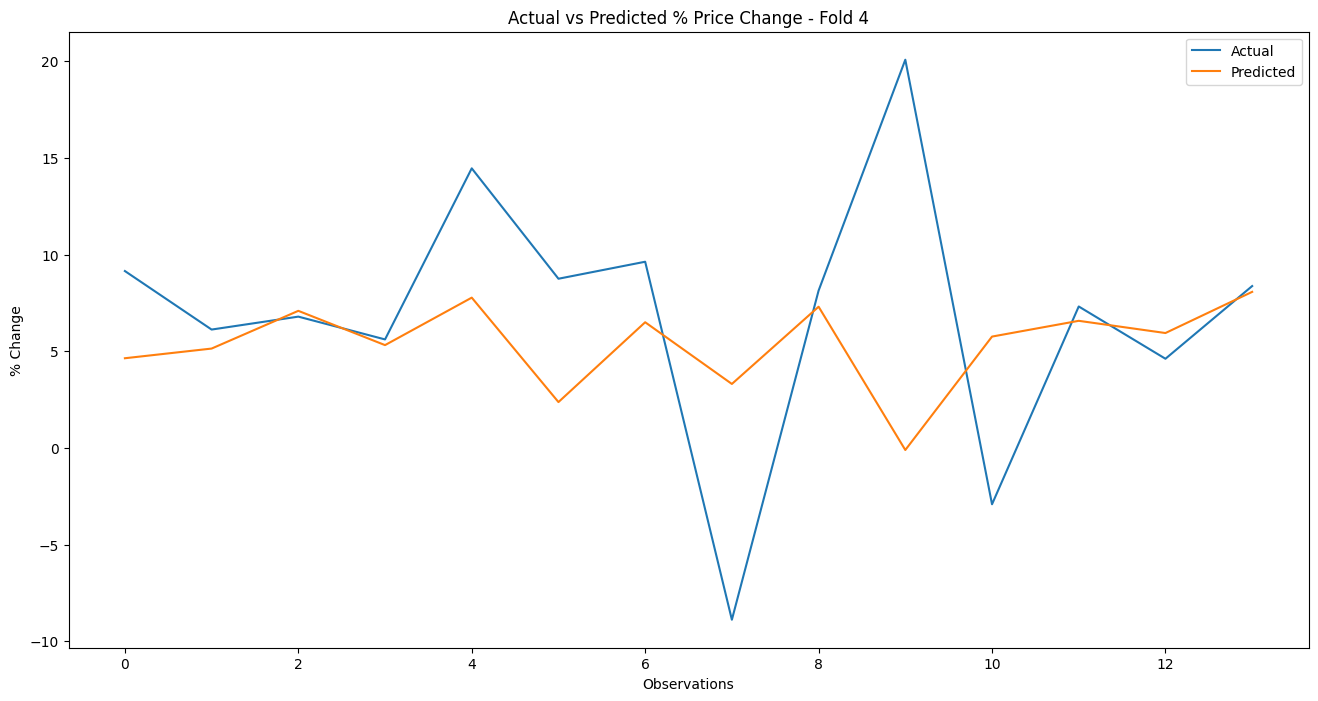

Epoch 1/200
2/2 [==============================] - 3s 10ms/step - loss: 0.3888 - mean_absolute_error: 0.5837
Epoch 2/200
2/2 [==============================] - 0s 10ms/step - loss: 0.3608 - mean_absolute_error: 0.5593
Epoch 3/200
2/2 [==============================] - 0s 9ms/step - loss: 0.3356 - mean_absolute_error: 0.5367
Epoch 4/200
2/2 [==============================] - 0s 9ms/step - loss: 0.3083 - mean_absolute_error: 0.5118
Epoch 5/200
2/2 [==============================] - 0s 10ms/step - loss: 0.2780 - mean_absolute_error: 0.4856
Epoch 6/200
2/2 [==============================] - 0s 12ms/step - loss: 0.2500 - mean_absolute_error: 0.4583
Epoch 7/200
2/2 [==============================] - 0s 10ms/step - loss: 0.2199 - mean_absolute_error: 0.4286
Epoch 8/200
2/2 [==============================] - 0s 8ms/step - loss: 0.1920 - mean_absolute_error: 0.3979
Epoch 9/200
2/2 [==============================] - 0s 8ms/step - loss: 0.1620 - mean_absolute_error: 0.3639
Epoch 10/200
2/2 [=====

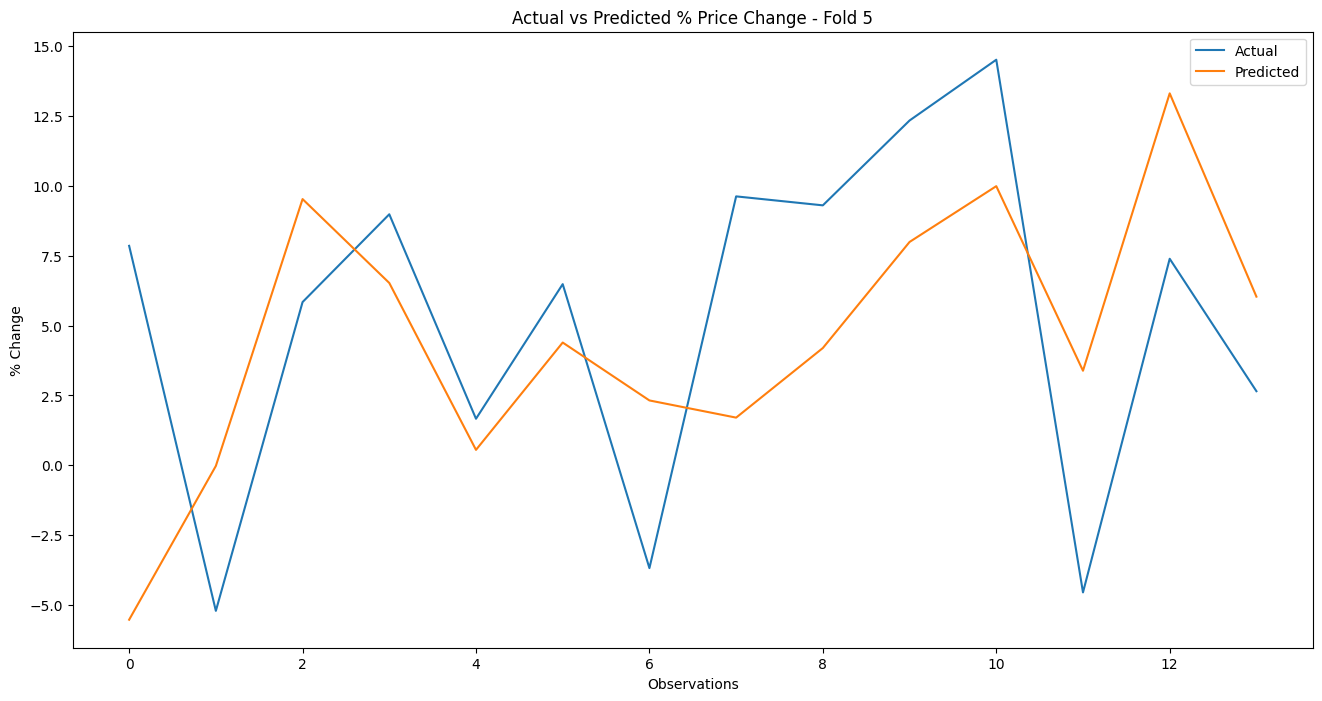

In [161]:
from sklearn.model_selection import KFold

# define 5-fold cross validation test harness
kfold = KFold(n_splits=5, shuffle=True)
fold_no = 1
for train, test in kfold.split(X_train, y_train):
    model = create_model()
    model.fit(X_train[train], y_train[train], epochs=200, batch_size=36, verbose=1)
    
    # Make predictions on the test data
    y_pred = model.predict(X_train[test])
    
    # Inverse scale the predicted data
    y_pred = y_scaler.inverse_transform(y_pred)
    
    # Inverse scale the actual data
    y_actual = y_scaler.inverse_transform(y_train[test])
    
    # Reshape for plotting
    y_actual = np.reshape(y_actual, y_actual.shape[0])
    y_pred = np.reshape(y_pred, y_pred.shape[0])
    
    # Plot the actual vs predicted data
    plt.figure(figsize=(16, 8))

    plt.plot(y_actual, label='Actual')
    plt.plot(y_pred, label='Predicted')

    plt.title('Actual vs Predicted % Price Change - Fold {}'.format(fold_no))
    plt.xlabel('Observations')
    plt.ylabel('% Change')
    plt.legend(loc='upper right')
    plt.show()

    fold_no += 1
